In [114]:
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import uuid
import os

from experiments.ModelLoader import load_vae_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 224x224
    transforms.ToTensor()  # convert to tensor & scale to [0,1]
])


dataset = datasets.ImageFolder(root="G:\Temp", transform=transform)
train_test_split_var = 0.999
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(train_test_split_var*len(dataset)), len(dataset) - int(train_test_split_var*len(dataset))])
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

def getDataMeanAndVariance(data_loader):
    sample_mus = None
    sample_var = None
    for batch_idx, (x, _) in enumerate(data_loader, start=1):
        model.encoder.eval()
        model.eval()
        x = x.to(device, non_blocking=True)
        mu, logvar = model.encoder(x)
        sample_mus = mu
        sample_var = logvar
        print(mu.shape)
        # save_reconstructions(model=model, x=x, out_dir=out_dir, step = 16, device=device, variant="test")
        break
    sample_mus = sample_mus.detach()
    sample_var = sample_var.detach()
    return sample_mus, sample_var

In [115]:
checkpoint_file = "./experiments/checkpoints/vae_checkpoint_epoch_16.pt"
latent_dim = 256
model = load_vae_model(checkpoint_path=checkpoint_file, device=device, latent_dim=latent_dim)
model.eval()
model.decoder.eval()
model.encoder.eval()

Encoder(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ELU(alpha=1.0)
  )
  (conv_mean): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv_logvar): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
)

torch.Size([16, 256, 2, 2])
torch.Size([16, 3, 64, 64])


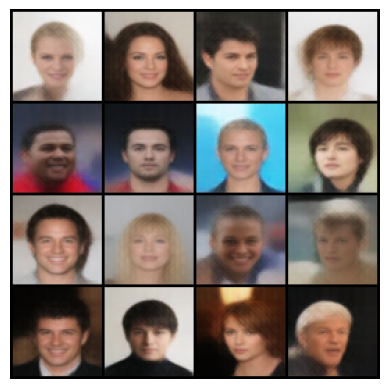

In [116]:
sample_mean, sample_logvar = getDataMeanAndVariance(test_loader)
def show(img_tensor, title=None, path=None, i_cur = 0):
    print(img_tensor.shape)
    img = make_grid(img_tensor, nrow=4, normalize=True, value_range=(0,1))

    # Convert (C,H,W) → (H,W,C)
    img = img.permute(1, 2, 0).cpu()

    # plt.imshow(img[:, :img.shape[1] // 2, :])
    # plt.figure(figsize=(64, 64))
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis("off")
    # plt.show()
    # plt.savefig(f"{path}/image{i_cur:04}.png", bbox_inches='tight', pad_inches=0)

with torch.no_grad():
    show(model.decoder(sample_mean))

torch.Size([3, 64, 64])


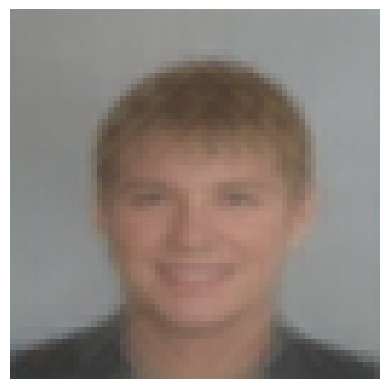

In [123]:
combined_image = (sample_mean[6] + sample_mean[9] + sample_mean[13] + sample_mean[12])/4
show(model.decoder(combined_image))

In [107]:
def showandSave(img_tensor, title=None, path=None, i_cur = 0):
    print(img_tensor.shape)
    img = make_grid(img_tensor, nrow=10, normalize=True, value_range=(0,1))

    # Convert (C,H,W) → (H,W,C)
    img = img.permute(1, 2, 0).cpu()

    # plt.imshow(img[:, :img.shape[1] // 2, :])
    # plt.figure(figsize=(64, 64))
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis("off")
    # plt.show()
    plt.savefig(f"{path}/image{i_cur:04}.png", bbox_inches='tight', pad_inches=0)

./demo/outputs/ed73862c-1bc8-4aaf-abac-7e973b1a43b5
torch.Size([6, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


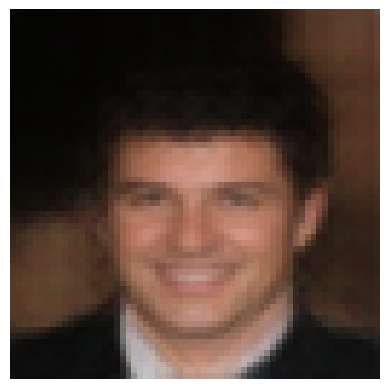

In [127]:
def showTransformation(first_img, second_img, output_dir = "./demo/outputs/",num_steps = 8):
    first_img = first_img.detach()
    second_img = second_img.detach()
    output_dir = output_dir + str(uuid.uuid4())
    os.makedirs(output_dir, exist_ok=True)
    print(output_dir)
    created_imgs = [model.decoder(first_img.unsqueeze(0))]

    for step in range(num_steps):
        alpha = step / num_steps
        interpolated = first_img + alpha * (second_img - first_img)
        # print(interpolated.unsqueeze(0).shape)
        created_imgs.append(model.decoder(interpolated.unsqueeze(0)))
    created_imgs.append( model.decoder(second_img.unsqueeze(0)))
    created_imgs = torch.cat(created_imgs, dim=0)
    print(created_imgs.shape)
    showandSave(created_imgs[0:1],i_cur=1, path=output_dir)
    for i in range(0,len(created_imgs)):
        showandSave(created_imgs[i:i+1],i_cur=i+1, path=output_dir)

showTransformation(combined_image,sample_mean[12], num_steps = 4)

In [ ]:
import random
import torch

# Number of interpolation steps
num_steps = 8

for _ in range(30):
    # Pick two random indices
    idx_start = random.randint(1, 30)
    idx_end = random.randint(1, 30)

    # Unique identifier for this interpolation
    interpolation_id = idx_start * 100 + idx_end

    # Get start and end latent vectors
    latent_start = sample_mean[idx_start]
    latent_end = sample_logvar[idx_end]

    # Initialize images with the starting latent
    images = [latent_start.unsqueeze(0)]
    print(latent_start.unsqueeze(0).shape)

    # Interpolation loop
    for step in range(num_steps + 1):
        alpha = step / num_steps  # fraction between start and end
        interpolated = (1 - alpha) * latent_start + alpha * latent_end
        print(interpolated.unsqueeze(0).shape)
        images.append(interpolated.unsqueeze(0))

    # Add the final latent
    images.append(latent_end.unsqueeze(0))

    # Create batch
    batch = torch.cat(images, dim=0)

    # Decode and save results
    showandSave(model.decoder(batch), i_cur=interpolation_id)
